# CAP 4410 Computer Vision Project 3 
## Name: Param Chokshi 
Code Refences: Dr. Sudeep Sarakar's Class Materials \\
https://github.com/SudeepSarkar/Undergraduate-Computer-Vision/blob/main/CAP_4410_Lecture_16__Convolutional_Neural_Networks.ipynb


## Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
!pip install d2l==0.16.2
from torchvision import transforms
import d2l
from google.colab import files
from torchsummary import summary

     |████████████████████████████████| 77 kB 2.9 MB/s 


## Define directory paths
* Mount google drive if using colab, and set the dir_path 
to the directory where you want to save and load all the trace files for plotting.

* If running locally, just set the dir_path
* I have provided files to plot all the tasks from my training, so if you don't want to re-train, set the dir_path to that folder and jump to the plotting section on the notebook
* This directory will also store the trained models

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Enter Home directory path. All the plots and traces for plots will be saved here. 
dir_path = "/content/drive/MyDrive/"

## Code: LeNet

In [5]:
def LeNet(convLayers, fcLayers, pooling, activation, kernel, outputChannels):

  layers = [] 

  layers.append(nn.Conv2d(in_channels=1, out_channels=outputChannels[0], kernel_size=kernel, padding=2))

  if activation == "Sigmoid":
    layers.append(nn.Sigmoid())
  elif activation == "ReLU":
    layers.append(nn.ReLU())
  elif activation == "LeakyReLU":
    layers.append(nn.LeakyReLU())
  elif activation == "Softmax":
    layers.append(nn.Softmax())

  if pooling == "AvgPool2d":
    layers.append(nn.AvgPool2d(kernel_size=2, stride=2))
  elif  pooling == "MaxPool2d":
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

  output_shape = int((round((28 - kernel + 2 * 2) / 1) + 1) / 2)
  #Formula to calculate output
  #output =  ((((input-kernel + 2*padding)/stride + 1) - pooling kernel size)/ pooling stride)  + 1
  #in our case pooling kernel and stride is 2 thus:
  #output = (((input-kernel + 2*padding)/stride + 1)/ 2) 
  fc_channels = output_shape ** 2 * outputChannels[0]

  if convLayers >= 2:
    layers.append(nn.Conv2d(in_channels=outputChannels[0],out_channels=outputChannels[1],kernel_size=kernel,padding=0))
    if activation == "Sigmoid":
      layers.append(nn.Sigmoid())
    elif activation == "ReLU":
      layers.append(nn.ReLU())
    elif activation == "LeakyReLU":
      layers.append(nn.LeakyReLU())
    elif activation == "Softmax":
      layers.append(nn.Softmax())

    if pooling == "AvgPool2d":
      layers.append(nn.AvgPool2d(kernel_size=2, stride=2))
    elif  pooling == "MaxPool2d":
      layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    output_shape = int((round((output_shape - kernel + 0) / 1) + 1) / 2)
    fc_channels = output_shape ** 2 * outputChannels[1]
  

  if convLayers == 3:
    layers.append(nn.Conv2d(in_channels=outputChannels[1],out_channels=outputChannels[1] * 2,kernel_size=kernel,padding=1))
    if activation == "Sigmoid":
      layers.append(nn.Sigmoid())
    elif activation == "ReLU":
      layers.append(nn.ReLU())
    elif activation == "LeakyReLU":
      layers.append(nn.LeakyReLU())
    elif activation == "Softmax":
      layers.append(nn.Softmax())

    output_shape = int((round((output_shape - kernel + 2) / 1) + 1))
    fc_channels = output_shape ** 2 * outputChannels[1] * 2


  layers.append(nn.Flatten())

  if fcLayers == 1:
    layers.append(nn.Linear(fc_channels, 10))
  else:
    layers.append(nn.Linear(fc_channels,120))
  if activation == "Sigmoid":
    layers.append(nn.Sigmoid())
  elif activation == "ReLU":
    layers.append(nn.ReLU())
  elif activation == "LeakyReLU":
    layers.append(nn.LeakyReLU())
  elif activation == "Softmax":
    layers.append(nn.Softmax())


  if fcLayers >= 2:
    if fcLayers == 2:
      layers.append(nn.Linear(120, 10))
    else:
      layers.append(nn.Linear(120,84))

    if activation == "Sigmoid":
      layers.append(nn.Sigmoid())
    elif activation == "ReLU":
      layers.append(nn.ReLU())
    elif activation == "LeakyReLU":
      layers.append(nn.LeakyReLU())
    elif activation == "Softmax":
      layers.append(nn.Softmax())

  if fcLayers == 3:
    layers.append(nn.Linear(84, 10))


  LeNet = nn.Sequential(*layers)
  LeNet.to(device)
  return LeNet

  


## Code (support): `Accumulator`



In [6]:
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # creates [0.0, 0.0, ....n-times]

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        # Example: let self.data = [10, 15] and args be [3, 4]
        # zip(self.data, args) will produce the paired iterable [(10, 3), (15, 4)]
        # the for loop with go over these paired entries adding them up to result in [13, 19]

    def reset(self):
        self.data = [0.0] * len(self.data) # creates [0.0, 0.0, ....n-times]

    def __getitem__(self, idx):
        return self.data[idx]

## Code (support): `evaluate_accuracy`

In [7]:
def accuracy (y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: #The output is a vector -- not just a scalar
        y_hat = y_hat.argmax(axis=1)
    cmp = (y_hat.type(y.dtype) == y)
    return float(cmp.type(y.dtype).sum())

In [8]:
def evaluate_accuracy (net, data_iter):  
    """Compute the accuracy for a model on a dataset."""
    net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions

    with torch.no_grad():
        for X, y in data_iter: # iterate over the minibatches
            X, y = X.to(device), y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

## Code: Fashion MNIST data

In [9]:
import torchvision.transforms as transforms
def FMNISTData(batch_size):
  FashionMNIST_classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 
                          'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
  transform_FashionMNIST = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5), (0.5))])


  trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                          download=True, transform=transform_FashionMNIST)
  testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                        download=True, transform=transform_FashionMNIST)


  train_iter = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
  test_iter = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
  return train_iter, test_iter






## Code: `train_full`

In [10]:
#-------------------------------------------------------------------------------
import time
def train_one_epoch (net, train_iter, loss, updater): 
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
            X, y = X.to(device), y.to(device) # Move data to device - GPU or CPU as set
            # Compute gradients and update parameters
            y_hat = net(X)
            l = loss(y_hat, y)
            
            # Using PyTorch in-built optimizer & loss criterion
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.numel())
        # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

#-------------------------------------------------------------------------------
def train_full (net, train_iter, test_iter, num_epochs, lr, init, opt): 

    # animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.1, 1.0],
    #                    legend=['train loss', 'train acc', 'test acc'])
    #----------------------Initialize-----------------------------------------
    # There is a default initialization in pytorch uses a uniform distribution bounded by 1/sqrt(in_features),
    # However, this might not be the best one to use. Weight initialization has a great impact on the
    # quality of the final network weights. 
    # Good discussions on initialization can be found at
    # https://towardsdatascience.com/how-to-initialize-a-neural-network-27564cfb5ffc
    # https://adityassrana.github.io/blog/theory/2020/08/26/Weight-Init.html
    # Below code allows you to use other well known initialization strategies.
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            if init == "Xavier":
              nn.init.xavier_normal_(m.weight)
              net.apply(init_weights)
            elif init == "Kaiming":
              nn.init.kaiming_normal_(m.weight)
              net.apply(init_weights)
            elif init == "None":
              None(m.weight)
              
           

      
    #-----------------------Loss Function--------------------------------------
    loss = nn.CrossEntropyLoss()
    #-----------------------Optimizer--------------------------------------
    # There are different kind of optimizers. The one we studied earlier, stochastic gradient descent (SGD)
    # is but only one type. There are more. See https://pytorch.org/docs/stable/optim.html
    # Adam optimizer is one the most popular one.
    #optimizer = torch.optim.SGD (net.parameters(), lr=lr, momentum=0.9)
    if opt == "Adam":
      optimizer = torch.optim.Adam (net.parameters(), lr=lr)
    elif opt == "RMSprop":
      optimizer = torch.optim.RMSprop (net.parameters(), lr=lr)
    elif opt == "SGD":
      optimizer = torch.optim.SGD (net.parameters(), lr=lr)

    #-----------------------Iterate over epochs--------------------------------------
    #Initialize list to save training accuracy, test accuracy, and loss over each epoch
    #Accuracy lists are initialized to have 0 as the first element, to help in plotting.
    #It represents that the accuracy of the model before training is 0
    tl_list = []
    ta_list = [0] 
    va_list = [0]

    for epoch in range(num_epochs):
        start_time = time.time()
        train_metrics = train_one_epoch (net, train_iter, loss, optimizer)
        train_loss, train_acc = train_metrics
        test_acc = evaluate_accuracy(net, test_iter)
        tl_list.append(train_loss)
        ta_list.append(train_acc)
        va_list.append(test_acc)
        end_time = time.time() - start_time    
        print ('Epoch:', epoch + 1, 'time: %4.3f'%(end_time), '(loss: %4.3f, train acc: %4.3f, test acc: %4.3f)'%(train_metrics[0],  train_metrics[1], test_acc))
        
    train_loss, train_acc = train_metrics
    return (tl_list, ta_list, va_list)

In [11]:
def save_plot(train_acc, val_acc, train_loss,var, name, path):
  i = 0
  plt.figure(figsize=(16, 8))
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title(name)
  for param in var:
    plt.plot(val_acc[i], label="Test_{}".format(param))
    plt.plot(train_acc[i], label="Train_{}".format(param))
    plt.plot(train_loss[i], label="Loss_{}".format(param))
    #write the accuracy and loss list to a .txt file to generate plot later.
    with open(path + name + str(param) + "_train.txt", "w") as file:
      file_lines = ",".join(list(map(str, train_acc[i])))
      file.write(file_lines)
    with open(path + name + str(param) +"_test.txt", "w") as file:
      file_lines = ",".join(list(map(str, val_acc[i])))
      file.write(file_lines)
    with open(path + name + str(param) + "_loss.txt", "w") as file:
      file_lines = ",".join(list(map(str, train_loss[i])))
      file.write(file_lines)
      i= i+1
  plt.legend()
  plt.savefig(path+name)
  plt.show()
  


## Code: Training

In [12]:
#default fixed hyperparameters
batch_size = 16
kernel = 5
outputChannels = [6,16]
pooling = "AvgPool2d"
activation = "Sigmoid"
convLayers = 2
fcLayers = 3
lrEpoch = [0.0001, 50]
init = "Xavier"
opt = "Adam"


Functions for each tasks are defined to help in training them seperately due to time constraints.

In [14]:
def task1():
  var = ["Adam", "RMSprop", "SGD"]
  net = LeNet(convLayers, fcLayers, pooling, activation, kernel, outputChannels)
  train_iter, test_iter = FMNISTData(batch_size)
  tl = []
  ta = []
  va = []
  for i in var:
    tl_list, ta_list, va_list = train_full(
        net=net,
        train_iter=train_iter, 
        test_iter=test_iter,
        num_epochs=lrEpoch[1], 
        lr=lrEpoch[0],
        init=init,
        opt=i
    )
    torch.save(net.state_dict(), path + "Optimizer_Variations_{}_checkpoint.pth".format(i))
    tl.append(tl_list)
    ta.append(ta_list)
    va.append(va_list)
  save_plot(ta, va, tl,var, "Optimizer_Variations", dir_path)


def task2():
  var = [16,32,64,256]
  net = LeNet(convLayers, fcLayers, pooling, activation, kernel, outputChannels)
  tl = []
  ta = []
  va = []

  for i in var:
    train_iter, test_iter = FMNISTData(i)
    tl_list, ta_list, va_list = train_full(
        net=net,
        train_iter=train_iter, 
        test_iter=test_iter,
        num_epochs=lrEpoch[1], 
        lr=lrEpoch[0],
        init=init,
        opt=opt
    )
    torch.save(net.state_dict(), path + "BatchSize_Variations_{}_checkpoint.pth".format(i))
    tl.append(tl_list)
    ta.append(ta_list)
    va.append(va_list)
  save_plot(ta, va, tl,var, "BatchSize_Variations",dir_path)

def task3():
  var = [3, 5, 7]
  
  train_iter, test_iter = FMNISTData(batch_size)
  tl = []
  ta = []
  va = []
  for i in var:
    net = LeNet(convLayers, fcLayers, pooling, activation, i, outputChannels)
    tl_list, ta_list, va_list = train_full(
        net=net,
        train_iter=train_iter, 
        test_iter=test_iter,
        num_epochs=lrEpoch[1], 
        lr=lrEpoch[0],
        init=init,
        opt=opt
    )
    torch.save(net.state_dict(), path + "Kernel_Variations_{}_checkpoint.pth".format(i))
    tl.append(tl_list)
    ta.append(ta_list)
    va.append(va_list)
  save_plot(ta, va, tl,var, "Kernel_Variations", dir_path)

def task4():
  var = [[4,12], [6,16], [8,20]]
  
  train_iter, test_iter = FMNISTData(batch_size)
  tl = []
  ta = []
  va = []
  for i in var:
    net = LeNet(convLayers, fcLayers, pooling, activation, kernel, i)
    tl_list, ta_list, va_list = train_full(
        net=net,
        train_iter=train_iter, 
        test_iter=test_iter,
        num_epochs=lrEpoch[1], 
        lr=lrEpoch[0],
        init=init,
        opt=opt
    )
    torch.save(net.state_dict(), path + "OutputChannel_Variations_{}_checkpoint.pth".format(i))
    tl.append(tl_list)
    ta.append(ta_list)
    va.append(va_list)
  save_plot(ta, va, tl,var, "OutputChannel_Variations", dir_path)

def task5():
  var = ["AvgPool2d", "MaxPool2d"]
  tl = []
  ta = []
  va = []
  train_iter, test_iter = FMNISTData(batch_size)

  for i in var:
    net = LeNet(convLayers, fcLayers, i, activation, kernel, outputChannels)
    tl_list, ta_list, va_list = train_full(
        net=net,
        train_iter=train_iter, 
        test_iter=test_iter,
        num_epochs=lrEpoch[1], 
        lr=lrEpoch[0],
        init=init,
        opt=opt
    )
    torch.save(net.state_dict(), path + "Pooling_Variations_{}_checkpoint.pth".format(i))
    tl.append(tl_list)
    ta.append(ta_list)
    va.append(va_list)
  save_plot(ta, va, tl,var, "Pooling_Variations", dir_path)

def task6():
  var = ["Softmax", "ReLU", "LeakyReLU"]
  tl = []
  ta = []
  va = []
  train_iter, test_iter = FMNISTData(batch_size)

  for i in var:
    net = LeNet(convLayers, fcLayers, pooling, i, kernel, outputChannels)
    tl_list, ta_list, va_list = train_full(
        net=net,
        train_iter=train_iter, 
        test_iter=test_iter,
        num_epochs=lrEpoch[1], 
        lr=lrEpoch[0],
        init=init,
        opt=opt
    )
    torch.save(net.state_dict(), path + "Activation_Variations_{}_checkpoint.pth".format(i))
    tl.append(tl_list)
    ta.append(ta_list)
    va.append(va_list)
  save_plot(ta, va, tl,var, "Activation_Variations", dir_path)

def task7():
  var = [2,1,3]
  
  train_iter, test_iter = FMNISTData(batch_size)
  tl = []
  ta = []
  va = []
  for i in var:
    net = LeNet(i, fcLayers, pooling, activation, kernel, outputChannels)
    tl_list, ta_list, va_list = train_full(
        net=net,
        train_iter=train_iter, 
        test_iter=test_iter,
        num_epochs=lrEpoch[1], 
        lr=lrEpoch[0],
        init=init,
        opt=opt
    )
    torch.save(net.state_dict(), path + "ConvLayers_Variations_{}_checkpoint.pth".format(i))
    tl.append(tl_list)
    ta.append(ta_list)
    va.append(va_list)
  save_plot(ta, va, tl,var, "ConvLayers_Variations", dir_path)

def task8():
  var = [3,1,2]
  
  train_iter, test_iter = FMNISTData(batch_size)
  tl = []
  ta = []
  va = []
  for i in var:
    net = LeNet(convLayers, i, pooling, activation, kernel, outputChannels)
    tl_list, ta_list, va_list = train_full(
        net=net,
        train_iter=train_iter, 
        test_iter=test_iter,
        num_epochs=lrEpoch[1], 
        lr=lrEpoch[0],
        init=init,
        opt=opt
    )
    torch.save(net.state_dict(), path + "FcLayers_Variations_{}_checkpoint.pth".format(i))
    tl.append(tl_list)
    ta.append(ta_list)
    va.append(va_list)
  save_plot(ta, va, tl,var, "FcLayers_Variations", dir_path)
def task9():
  var = [[0.0001, 50], [0.00001, 1000],[0.0001, 500],[0.001, 250],[0.01, 100],[0.1, 50] ]
  net = LeNet(convLayers, fcLayers, pooling, activation, kernel, outputChannels)
  train_iter, test_iter = FMNISTData(batch_size)
  tl = []
  ta = []
  va = []
  for i in var:
    
    tl_list, ta_list, va_list = train_full(
        net=net,
        train_iter=train_iter, 
        test_iter=test_iter,
        num_epochs=i[1], 
        lr=i[0],
        init=init,
        opt=opt
    )
    torch.save(net.state_dict(), path + "LR_Epoch_Variations_{}_checkpoint.pth".format(i))
    tl.append(tl_list)
    ta.append(ta_list)
    va.append(va_list)
  save_plot(ta, va, tl,var, "LR_Epoch_Variations", dir_path)

def task10():
  var = ["Xavier", "Kaiming", "None"]
  net = LeNet(convLayers, fcLayers, pooling, activation, kernel, outputChannels)
  train_iter, test_iter = FMNISTData(batch_size)
  tl = []
  ta = []
  va = []
  for i in var:
    
    tl_list, ta_list, va_list = train_full(
        net=net,
        train_iter=train_iter, 
        test_iter=test_iter,
        num_epochs=lrEpoch[1], 
        lr=lrEpoch[0],
        init=i,
        opt=opt
    )
    torch.save(net.state_dict(), path + "Intialization_Variations_{}_checkpoint.pth".format(i))
    tl.append(tl_list)
    ta.append(ta_list)
    va.append(va_list)
  save_plot(ta, va, tl,var, "Intialization_Variations", dir_path)

The function provides the option to run task seperately, or to run all of them together.

In [15]:
#Enter the task number you would like to run, enter 0 (default) to run all tasks
def run_tasks(num=0):
  if num == 1 or num == 0:
    task1()
  if num == 2 or num == 0:
    task2()
  if num == 3 or num == 0:
    task3()
  if num == 4 or num == 0:
    task4()
  if num == 5 or num == 0:
    task5()
  if num == 6 or num == 0:
    task6()
  if num == 7 or num == 0:
    task7()
  if num == 8 or num == 0:
    task8()
  if num == 9 or num == 0:
    task9()
  if num == 10 or num == 0:
    task10()

Execute this cell to start training. If you don't give the task number to run_tasks() function, it will run all the tasks by default.

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Epoch: 1 time: 42.983 (loss: 0.846, train acc: 0.679, test acc: 0.760)
Epoch: 2 time: 42.754 (loss: 0.520, train acc: 0.800, test acc: 0.804)
Epoch: 3 time: 45.105 (loss: 0.452, train acc: 0.833, test acc: 0.834)
Epoch: 4 time: 45.989 (loss: 0.411, train acc: 0.848, test acc: 0.842)
Epoch: 5 time: 46.519 (loss: 0.381, train acc: 0.859, test acc: 0.848)
Epoch: 6 time: 43.852 (loss: 0.359, train acc: 0.868, test acc: 0.856)
Epoch: 7 time: 42.732 (loss: 0.340, train acc: 0.874, test acc: 0.867)
Epoch: 8 time: 42.891 (loss: 0.327, train acc: 0.879, test acc: 0.867)
Epoch: 9 time: 43.475 (loss: 0.313, train acc: 0.884, test acc: 0.873)
Epoch: 10 time: 42.802 (loss: 0.302, train acc: 0.887, test acc: 0.869)
Epoch: 11 time: 42.843 (loss: 0.295, train acc: 0.889, test acc: 0.877)
Epoch: 12 time: 43.098 (loss: 0.285, train acc: 0.893, test acc: 0.875)
Epoch: 13 time: 42.917 (loss: 0.277, train acc: 0.897, t

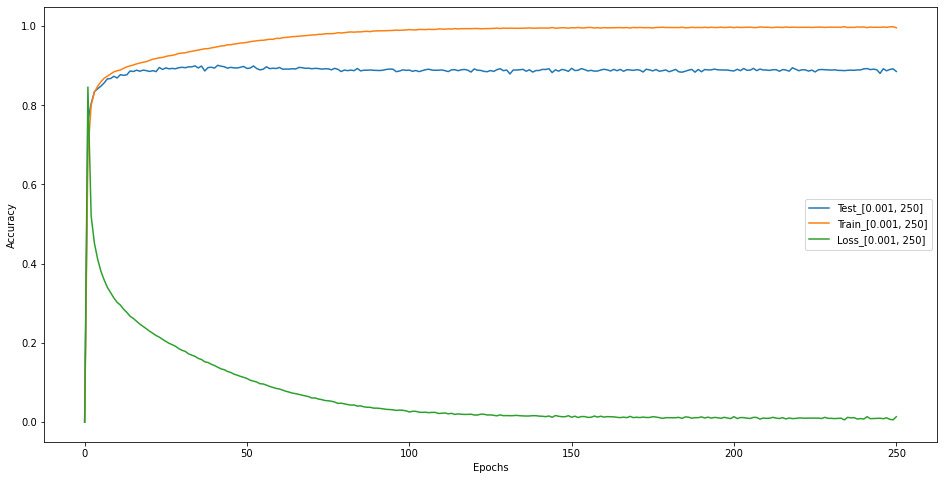

<Figure size 432x288 with 0 Axes>

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#Enter the task number you would like to run, enter 0 (default) to run all tasks
run_tasks(0)

## Code: Plotting
* This section can be run independently of the training section. I have provided all the files to do the plotting in a folder. Make sure that , the dir_path (refer define directory paths section) represents the correct folder.

* Define all the combinations of tasks variations. 
* Initialize a list to store best variation from each task.

In [4]:
tasks = ["Optimizer_Variations", "BatchSize_Variations","Kernel_Variations", "OutputChannel_Variations","Pooling_Variations",
        "Activation_Variations", "ConvLayers_Variations", "FcLayers_Variations", "LR_Epoch_Variations", "Intialization_Variations"]
tasks_param = [["Adam", "RMSprop", "SGD"], 
               [16,32,64,256], 
               [3, 5, 7],  
               [[4,12], [6,16], [8,20]],
               ["AvgPool2d", "MaxPool2d"], 
               ["Softmax", "ReLU", "LeakyReLU"], 
               [2,1,3], 
               [3,1,2], 
               [[0.0001, 50], [0.0001, 500],[0.001, 250],[0.01, 100],[0.1, 50], [0.00001, 1000]],
               ["Xavier", "Kaiming", "None"]]
best_param = []



Helper Function to read the .txt files containing training accuracy list and  test accuracy list, and plot all the variations on a task in 1 figure.

In [5]:
def load_data(var, name, path):
  i = 0
  plt.figure(figsize=(10, 8)) #16
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.ylim([0.1,1.2])
  best_val_acc = 0
  best_var = var[0]
  for param in var:
    file = open(path + name + str(param) + "_train.txt", "r")
    file_lines = file.read()
    train_acc = file_lines.split(",")
    train_acc = list(map(float, train_acc))
    file = open(path + name + str(param) + "_test.txt", "r")
    file_lines = file.read()
    val_acc = file_lines.split(",")
    val_acc = list(map(float, val_acc))
    file = open(path + name + str(param) + "_loss.txt", "r")
    file_lines = file.read()
    train_loss = file_lines.split(",")
    train_loss = list(map(float, train_acc))
    if val_acc[-1] > best_val_acc:
      best_val_acc = val_acc[-1]
      best_var = param
    plt.plot(val_acc, '-', label="Test_{}".format(param))
    plt.plot(train_acc, ':',label="Train_{}".format(param))

  best_param.append([name, best_var])
  plt.legend()
  plt.title(name)
  plt.savefig(path + name + "_plot.png")
  plt.show()

* Helper function to plot all the task
* Helper function to read the best parameters list and plot the best variation from eac task into one figure.
* The best plot has a set xlim of 60, this is done to help compare visually the tasks with each other in the case where the best case for # of epochs greater than 50

In [6]:
def plot(path):
  for i in range(0,10):
    load_data(tasks_param[i], tasks[i], path)

def plot_best(path):
  plt.figure(figsize=(12, 12))#20
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.ylim([0.1,1.2])
  plt.xlim([0,60])
  plt.title("Best Hyperparameters")
  #plt.rc('axes', prop_cycle=custom_cycler)
  for i in range(0,10):
    file = open(path + best_param[i][0] + str(best_param[i][1]) + "_train.txt", "r")
    file_lines = file.read()
    train_acc = file_lines.split(",")
    train_acc = list(map(float, train_acc))
    file = open(path + best_param[i][0] + str(best_param[i][1]) + "_test.txt", "r")
    file_lines = file.read()
    val_acc = file_lines.split(",")
    val_acc = list(map(float, val_acc))

    plt.plot(val_acc, '-', label="Test_{}_{}".format(best_param[i][0], best_param[i][1]))
    plt.plot(train_acc,':', label="Train_{}_{}".format(best_param[i][0], best_param[i][1]))

  plt.legend()
  plt.savefig(path + "Best Hyperparameters" + "_plot.png")
  plt.show()



* Plot the figures, and print the best parameter list
* Note: All of the plots are saved in the folder given by dir_path

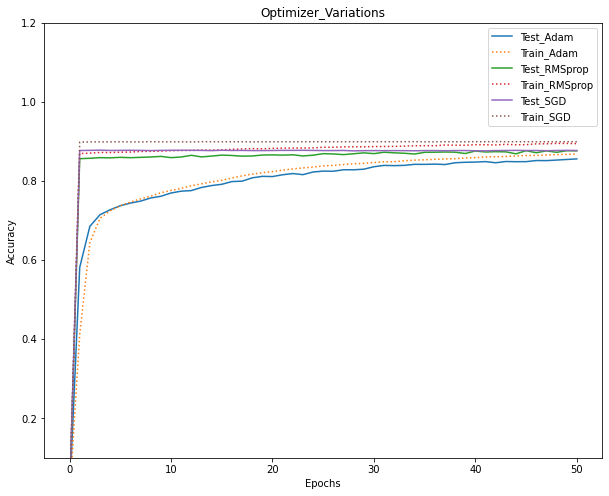

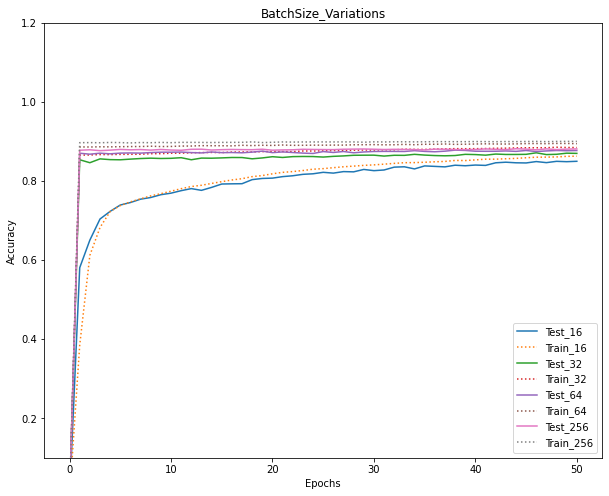

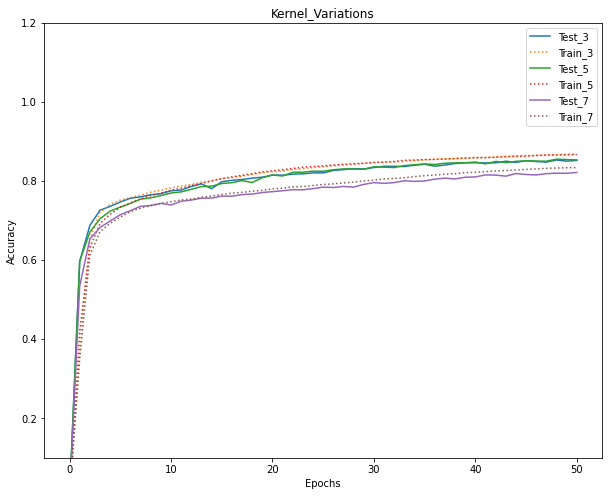

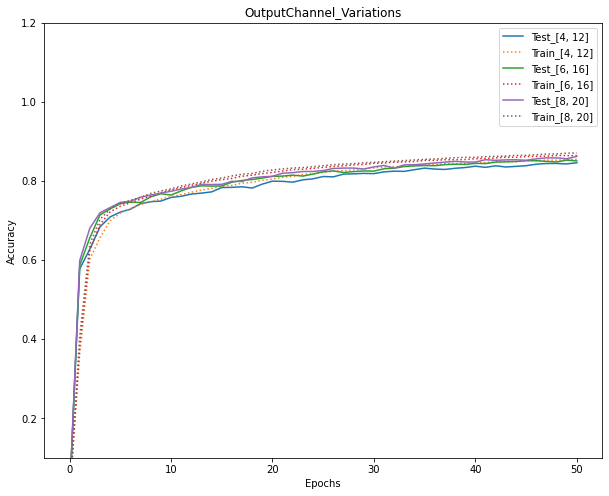

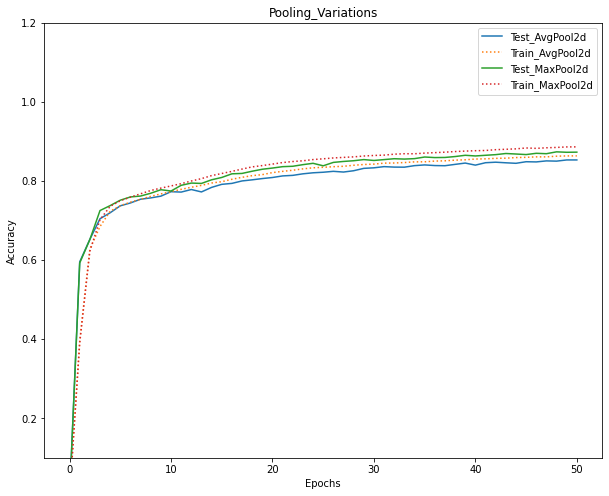

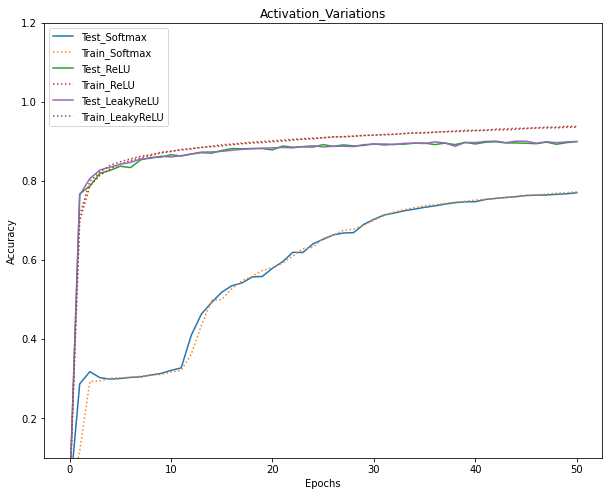

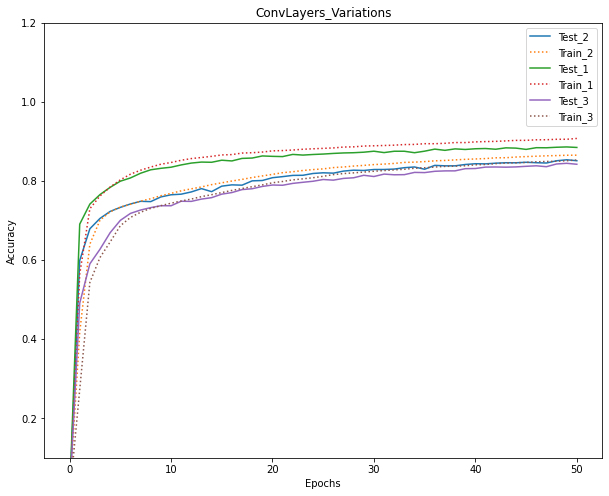

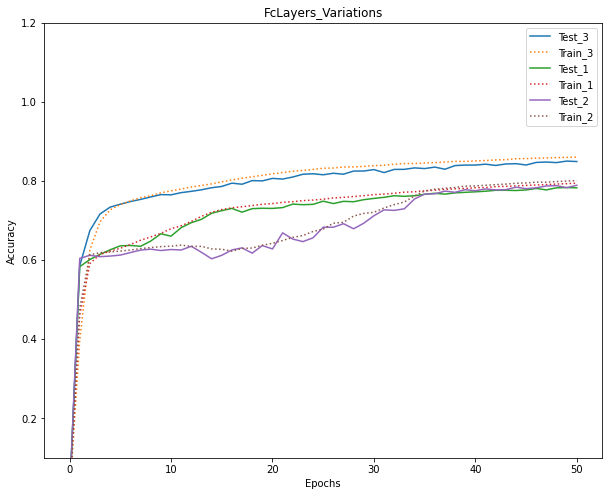

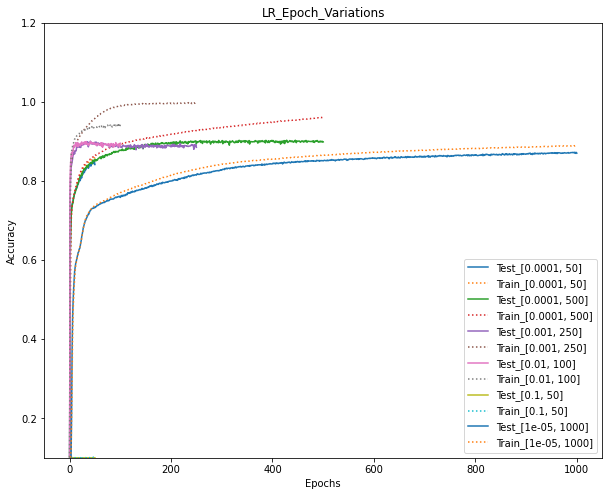

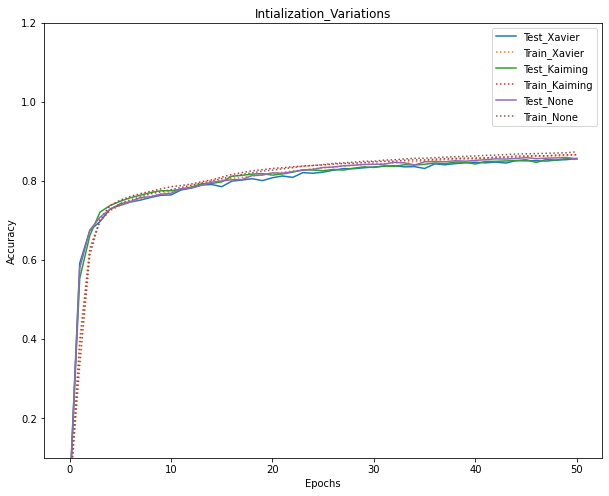

[['Optimizer_Variations', 'SGD'], ['BatchSize_Variations', 256], ['Kernel_Variations', 5], ['OutputChannel_Variations', [8, 20]], ['Pooling_Variations', 'MaxPool2d'], ['Activation_Variations', 'LeakyReLU'], ['ConvLayers_Variations', 1], ['FcLayers_Variations', 3], ['LR_Epoch_Variations', [0.0001, 500]], ['Intialization_Variations', 'Xavier']]


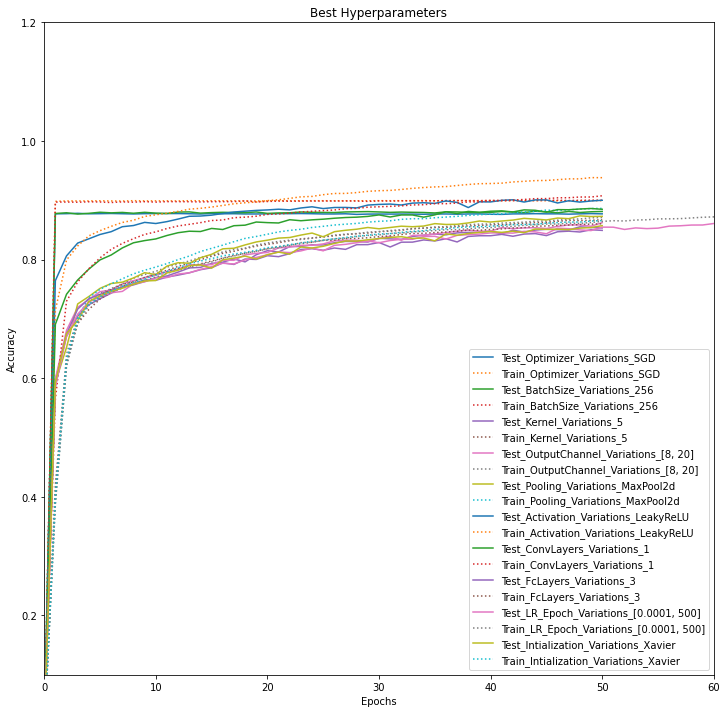

In [7]:
plot(dir_path)
print(best_param)
plot_best(dir_path)